##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

本教程演示了從存儲在磁盤上的純文本文件開始的文本分類。您將訓練一個二元分類器來對 IMDB 數據集執行情感分析。在筆記本的最後，有一個練習供您嘗試，您將在其中訓練一個多類分類器來預測 Stack Overflow 上編程問題的標籤。

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [2]:
print(tf.__version__)

2.9.1


## 情緒分析

這個筆記本訓練了一個情感分析模型，根據評論的文本將電影評論分類為*正面*或*負面*。這是*二元*（或二類）分類的一個示例，這是一種重要且廣泛適用的機器學習問題。
您將使用 [大型電影評論數據集](https://ai.stanford.edu/~amaas/data/sentiment/)，其中包含來自 [互聯網電影數據庫](https://www.imdb.com/)。這些分為 25,000 條培訓評論和 25,000 條測試評論。訓練集和測試集是*平衡的*，這意味著它們包含相同數量的正面和負面評論。


### 下載並探索 IMDB 數據集

讓我們下載並提取數據集，然後探索目錄結構。

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

`aclImdb/train/pos` 和 `aclImdb/train/neg` 目錄包含許多文本文件，每個文件都是一個電影評論。讓我們來看看其中一個。

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### 加載數據集

接下來，您將從磁盤加載數據並將其準備為適合訓練的格式。為此，您將使用有用的 [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) 實用程序，它需要如下目錄結構。

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

要為二進制分類準備數據集，您將需要磁盤上的兩個文件夾，對應於 `class_a` 和 `class_b`。這些將是正面和負面的電影評論，可以在 `aclImdb/train/pos` 和 `aclImdb/train/neg` 中找到。由於 IMDB 數據集包含其他文件夾，因此您將在使用此實用程序之前將其刪除。

In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

接下來，您將使用 `text_dataset_from_directory` 實用程序創建一個標記為 `tf.data.Dataset`。 [tf.data](https://www.tensorflow.org/guide/data) 是一個強大的數據處理工具集合。

在運行機器學習實驗時，最好將數據集分成三個部分：[train](https://developers.google.com/machine-learning/glossary#training_set)、[validation](https://developers.google.com/machine-learning/glossary#validation_set)和[test](https://developers.google.com/machine-learning/glossary#test-set)。

IMDB 數據集已經分為訓練和測試，但缺少驗證集。讓我們使用下面的 `validation_split` 參數，使用 80:20 的訓練數據拆分來創建一個驗證集。

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


正如您在上面看到的，訓練文件夾中有 25,000 個示例，您將使用其中的 80%（或 20,000 個）進行訓練。正如您稍後將看到的，您可以通過將數據集直接傳遞給“model.fit”來訓練模型。如果您是 `tf.data` 的新手，您還可以遍歷數據集並打印出一些示例，如下所示。

In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

請注意，評論包含原始文本（帶有標點符號和偶爾的 HTML 標籤，如 `<br/>`）。您將在下一節中展示如何處理這些問題。

標籤是 0 或 1。要查看其中哪些對應於正面和負面的電影評論，您可以檢查數據集上的 `class_names` 屬性。


In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


接下來，您將創建一個驗證和測試數據集。您將使用訓練集中剩餘的 5,000 條評論進行驗證。

注意：使用 `validation_split` 和 `subset` 參數時，請確保指定隨機種子或傳遞 `shuffle=False`，以便驗證和訓練拆分沒有重疊。

In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### 準備數據集進行訓練

接下來，您將使用有用的 `tf.keras.layers.TextVectorization` 層對數據進行標準化、標記化和矢量化。
標準化是指預處理文本，通常是刪除標點符號或 HTML 元素以簡化數據集。標記化是指將字符串拆分為標記（例如，通過在空格上拆分，將句子拆分為單個單詞）。矢量化是指將標記轉換為數字，以便將它們輸入神經網絡。所有這些任務都可以通過這一層來完成。
正如您在上面看到的，評論包含各種 HTML 標記，例如 `<br />`。 `TextVectorization` 層中的默認標準化程序不會刪除這些標籤（默認情況下它將文本轉換為小寫並去除標點符號，但不會去除 HTML）。您將編寫一個自定義標準化函數來刪除 HTML。

注意：為了防止 [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（也稱為 training-serving skew），重要的是在訓練和測試時對數據進行相同的預處理。為此，可以將“TextVectorization”層直接包含在模型中，如本教程後面所示

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

接下來，您將創建一個“TextVectorization”層。您將使用該層來標準化、標記化和矢量化我們的數據。您將 `output_mode` 設置為 `int` 以為每個標記創建唯一的整數索引。
請注意，您使用的是默認拆分功能，以及您在上面定義的自定義標準化功能。您還將為模型定義一些常量，例如顯式的最大 `sequence_length`，這將導致層將序列填充或截斷為精確的 `sequence_length` 值。


In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

接下來，您將調用 `adapt` 以使預處理層的狀態適應數據集。這將導致模型建立字符串到整數的索引。

注意：在調用 adapt 時只使用訓練數據很重要（使用測試集會洩漏信息）。

In [15]:
# 製作一個純文本數據集（沒有標籤），然後調用 adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

讓我們創建一個函數來查看使用該層預處理一些數據的結果。

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# 從數據集中檢索一批（32 條評論和標籤）
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

正如你在上面看到的，每個標記都被一個整數替換了。您可以通過在圖層上調用 `.get_vocabulary()` 來查找每個整數對應的標記（字符串）。

In [19]:
print("86 ---> ",vectorize_layer.get_vocabulary()[86])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

86 --->  great
 313 --->  night
Vocabulary size: 10000


你幾乎準備好訓練你的模型了。作為最後的預處理步驟，您將之前創建的 TextVectorization 層應用於訓練、驗證和測試數據集。

In [23]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### 為性能配置數據集

這是加載數據時應使用的兩種重要方法，以確保 I/O 不會阻塞。

`.cache()` 將數據從磁盤加載後保存在內存中。這將確保數據集在訓練模型時不會成為瓶頸。如果您的數據集太大而無法放入內存，您還可以使用此方法創建一個高性能的磁盤緩存，這比許多小文件的讀取效率更高。
`.prefetch()` 在訓練時與數據預處理和模型執行重疊。

您可以在 [數據性能指南](https://www.tensorflow.org/guide/data_performance) 中了解有關這兩種方法的更多信息，以及如何將數據緩存到磁盤。


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 創建模型

是時候創建你的神經網絡了：

In [25]:
embedding_dim = 16

In [26]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

這些層按順序堆疊以構建分類器：

1. 第一層是`Embedding`層。該層採用整數編碼的評論，並為每個詞索引查找一個嵌入向量。這些向量是作為模型訓練來學習的。向量向輸出數組添加一個維度。結果維度是：`(batch, sequence, embedding)`。要了解有關嵌入的更多信息，請查看 [詞嵌入](https://www.tensorflow.org/text/guide/word_embeddings) 教程。
2. 接下來，`GlobalAveragePooling1D` 層通過對序列維度進行平均來為每個示例返回一個固定長度的輸出向量。這允許模型以最簡單的方式處理可變長度的輸入。
3. 這個固定長度的輸出向量通過具有 16 個隱藏單元的全連接（“密集”）層進行管道傳輸。
4. 最後一層與單個輸出節點密集連接。

### 損失函數和優化器

模型需要一個損失函數和一個優化器來進行訓練。由於這是一個二元分類問題並且模型輸出概率（具有 sigmoid 激活的單單元層），您將使用 losses.BinaryCrossentropy 損失函數。

In [27]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### 訓練模型

您將通過將“數據集”對像傳遞給 fit 方法來訓練模型。

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 27s 40ms/step - loss: 0.6656 - binary_accuracy: 0.6938 - val_loss: 0.6180 - val_binary_accuracy: 0.7716
Epoch 2/10
625/625 [==============================] - 13s 21ms/step - loss: 0.5518 - binary_accuracy: 0.8005 - val_loss: 0.5014 - val_binary_accuracy: 0.8218
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 0.4475 - binary_accuracy: 0.8447 - val_loss: 0.4220 - val_binary_accuracy: 0.8466
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 0.3802 - binary_accuracy: 0.8659 - val_loss: 0.3750 - val_binary_accuracy: 0.8596
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 0.3374 - binary_accuracy: 0.8789 - val_loss: 0.3459 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 0.3060 - binary_accuracy: 0.8877 - val_loss: 0.3266 - val_binary_accuracy: 0.8722
Epoch 7/10
625/625 [==============================] 

### 評估模型

讓我們看看模型的表現如何。將返回兩個值。損失（代表我們的錯誤的數字，較低的值更好）和準確性。

In [29]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 19s 25ms/step - loss: 0.3106 - binary_accuracy: 0.8728
Loss:  0.31056976318359375
Accuracy:  0.8727999925613403


這種相當幼稚的方法實現了大約 86% 的準確度。

### 創建一個隨時間變化的準確度和損失圖

`model.fit()` 返回一個 `History` 對象，其中包含一個字典，其中包含訓練期間發生的所有事情：

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

有四個條目：一個用於訓練和驗證期間的每個監控指標。您可以使用這些來繪製訓練和驗證損失以進行比較，以及訓練和驗證準確性：

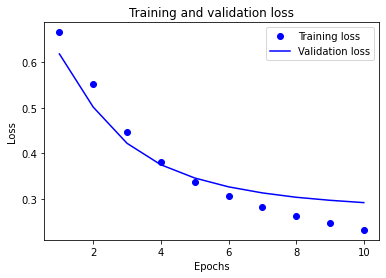

In [31]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

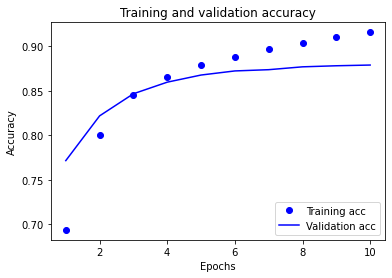

In [32]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

在該圖中，點表示訓練損失和準確率，實線表示驗證損失和準確率。

請注意，每個時期的訓練損失*減少*，並且每個時期的訓練準確度*增加*。這在使用梯度下降優化時是預期的——它應該在每次迭代中最小化所需的數量。
驗證損失和準確度並非如此——它們似乎在訓練準確度之前達到峰值。這是一個過擬合的例子：模型在訓練數據上的表現比它在從未見過的數據上表現得更好。在此之後，模型會過度優化並學習*特定*特定於訓練數據的表示，這些表示不會*泛化*到測試數據。
對於這種特殊情況，您可以通過在驗證準確度不再增加時停止訓練來防止過度擬合。一種方法是使用 `tf.keras.callbacks.EarlyStopping` 回調。

## 導出模型

在上面的代碼中，您在將文本輸入模型之前將“TextVectorization”層應用於數據集。如果你想讓你的模型能夠處理原始字符串（例如，為了簡化它的部署），你可以在你的模型中包含 `TextVectorization` 層。為此，您可以使用剛剛訓練的權重創建一個新模型。

In [33]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 28s 35ms/step - loss: 0.3106 - accuracy: 0.8728
0.8727999925613403


### 推斷新數據

要獲得新示例的預測，您可以簡單地調用`model.predict()`。

In [34]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 234ms/step


array([[0.6196926 ],
       [0.4414351 ],
       [0.35855487]], dtype=float32)

在模型中包含文本預處理邏輯使您能夠導出用於生產的模型，從而簡化部署並減少 [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)的可能性。

在選擇應用 TextVectorization 圖層的位置時，需要牢記性能差異。在您的模型之外使用它可以讓您在 GPU 上訓練時進行異步 CPU 處理和數據緩衝。因此，如果您在 GPU 上訓練模型，您可能希望在開發模型時使用此選項以獲得最佳性能，然後在準備好部署時切換到在模型中包含 TextVectorization 層。

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## 練習：關於 Stack Overflow 問題的多類分類

本教程展示瞭如何在 IMDB 數據集上從頭開始訓練二元分類器。作為練習，您可以修改此筆記本以訓練多類分類器來預測 [Stack Overflow](http://stackoverflow.com/) 上的編程問題的標籤。


已為您準備了一個 [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) 供您使用，其中包含發佈到 Stack Overflow 的數千個編程問題（例如，“如何在 Python 中按值對字典進行排序？”）。其中每一個都用一個標籤（Python、CSharp、JavaScript 或 Java）進行標記。您的任務是將問題作為輸入，並預測適當的標籤，在本例中為 Python。

您將使用的數據集包含從 [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) 上更大的公共 Stack Overflow 數據集中提取的數千個問題，其中包含超過 1700 萬個帖子。


下載數據集後，您會發現它的目錄結構與您之前使用的 IMDB 數據集相似：

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

注意：為了增加分類問題的難度，編程問題中出現的單詞 Python、CSharp、JavaScript 或 Java 已替換為單詞 *blank*（因為許多問題都包含它們所涉及的語言）。

要完成此練習，您應該通過進行以下修改來修改此筆記本以使用 Stack Overflow 數據集：

1. 在筆​​記本頂部，將下載IMDB數據集的代碼更新為下載已經準備好的[Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) 的代碼。由於 Stack Overflow 數據集具有類似的目錄結構，因此您無需進行很多修改。


1. 將模型的最後一層修改為“Dense(4)”，因為現在有四個輸出類。

1. 編譯模型時，將損失更改為`tf.keras.losses.SparseCategoricalCrossentropy`。這是用於多類分類問題的正確損失函數，當每個類的標籤是整數時（在這種情況下，它們可以是 0、*1*、*2*或 *3*）。此外，將指標更改為 `metrics=['accuracy']`，因為這是一個多類分類問題（`tf.metrics.BinaryAccuracy` 僅用於二元分類器）。

1. 當繪製隨時間變化的精度時，將 `binary_accuracy` 和 `val_binary_accuracy` 分別更改為 `accuracy` 和 `val_accuracy`。

1. 完成這些更改後，您將能夠訓練多類分類器。

## 學習更多

本教程從頭開始介紹文本分類。要了解有關文本分類工作流程的更多信息，請查看 Google Developers 的 [文本分類指南](https://developers.google.com/machine-learning/guides/text-classification/)。

